Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
DATA = "bin"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

THRESHOLD = 0.999 # доля белого
# THRESHOLD = 0.994
BATCH_SIZE = 8
EPOCHES = 100
PATH = "m.pth"
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms
from time import time

from src.functions import *
from src.dataset import *
from src.train import *

print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [4]:
"seed_everything(42)"

'seed_everything(42)'

# Dataset

In [5]:
class My_Dataset(Dataset):
    def __init__(
        self, kind, images_dir, augmentation, transform, threshold, deterministic=True, seed=42
    ):
        self.kind = 1 if kind == "pos" else 0
        self.augmentation = augmentation
        self.transform = transform
        self.deterministic = deterministic

        self.files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in self.files_names]

        self.real_len = len(self.files_names)
        self.required_len = self.augmentation * self.real_len

        if self.deterministic:
            seed_everything(seed)
            self.X = []

            i = 0
            while len(self.X) < self.required_len:
                image = Image.open(self.image_paths[i % self.real_len])
                i += 1

                dol = 1
                k = 0
                while dol >= threshold:
                    transformed_image = self.transform(image)

                    x, col = np.unique(transformed_image.max(dim = 0)[0], return_counts = True)
                    ones = col[np.where(x == 1)[0]][0]
                    dol = ones / col.sum() # доля белого
                    k += 1
                    if k > 100:
                        print(f"Доля белого больше у {i} картинки!!!")
                        break

                self.X.append((transformed_image, self.kind))

    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                image = Image.open(self.image_paths[idx % self.real_len])
                return self.transform(image), self.kind
        else:
            raise IndexError

In [6]:
data_transform = transforms.Compose([
    transforms.RandomCrop(300),
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

pos_dataset = My_Dataset("pos", DATA_POS, augmentation=22, transform=data_transform,
                         threshold=THRESHOLD) # 11
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = My_Dataset("neg", DATA_NEG, augmentation=2, transform=data_transform,
                         threshold=THRESHOLD) # 1
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

Positive: 484    (22)
Negative: 448    (224)
ConcatDataset: 932


In [7]:
# в тренировочную выборку отнесем 80% всех картинок

train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

seed_everything(42)
train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 745
 Test: 187


# Dataloader

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 94
 Test batches: 24


In [9]:
pos_neg(train_loader)

{'1': 381, '0': 364, 'total': 745}

In [10]:
pos_neg(test_loader)

{'1': 103, '0': 84, 'total': 187}

torch.Size([8, 3, 224, 224]) tensor([1, 1, 0, 0, 1, 1, 1, 0])


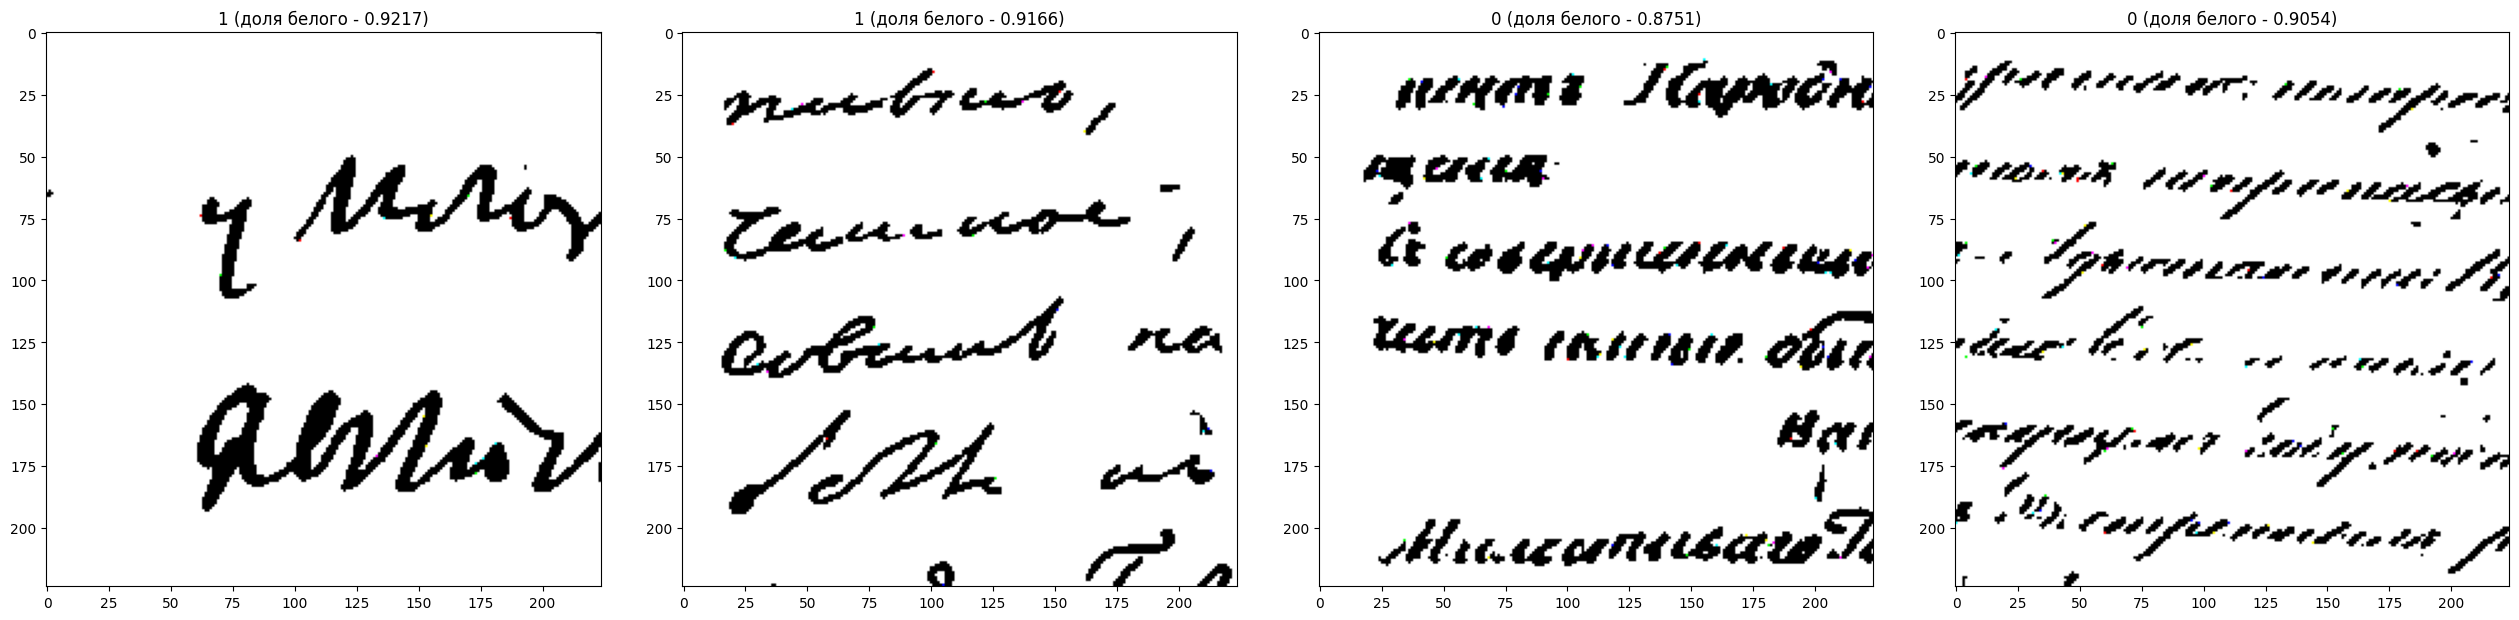

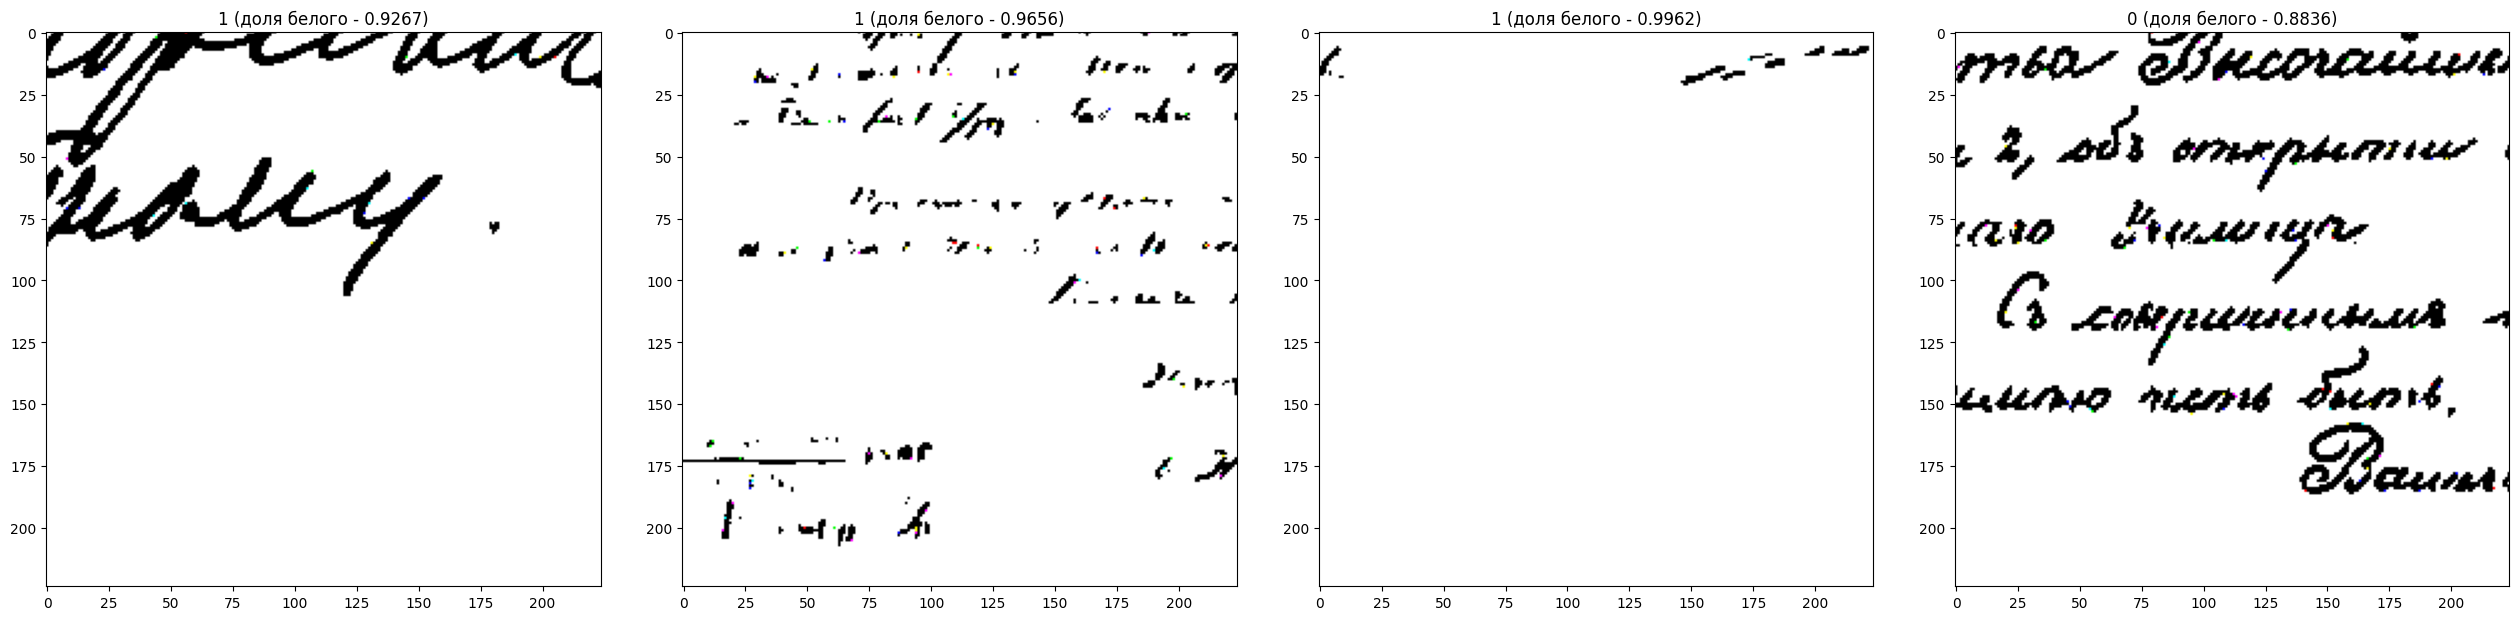

In [11]:
images, labels = next(iter(test_loader))
print(images.shape, labels)
show_batch(images, labels, 8)

# freeze_layers

In [12]:
def number_of_parameters(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters"

In [13]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)
number_of_parameters(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


'11689512 parameters'

In [14]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [15]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

seed_everything(42)
model = create_model(model, num_layers - 1, num_classes).to(DEVICE)

Число слоёв: 10
Число классов: 2


In [16]:
number_of_parameters(model)

'1026 parameters'

In [17]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [18]:
# for i, layer in enumerate(model.children()):
#     for param in layer.parameters():
#         if param.requires_grad:
#             print(i, layer, param.shape, param, param.requires_grad, sep = "\n")

In [ ]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

In [19]:
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

<All keys matched successfully>

# train

In [20]:
start_time = time()

seed_everything(42)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=EPOCHES)
torch.save(model.state_dict(), PATH)

print(f"# Время работы: {(time() - start_time):6.5f}s")

# Epoch: 1
# Эпоха 1/100 train/val: loss 0.70699/0.65729, accuracy: 0.51812/0.60428
# Epoch: 2
# Эпоха 2/100 train/val: loss 0.66187/0.62309, accuracy: 0.58926/0.69519
# Epoch: 3
# Эпоха 3/100 train/val: loss 0.62693/0.59932, accuracy: 0.62685/0.73797
# Epoch: 4
# Эпоха 4/100 train/val: loss 0.60036/0.58124, accuracy: 0.6604/0.74866
# Epoch: 5
# Эпоха 5/100 train/val: loss 0.57906/0.56667, accuracy: 0.68054/0.75936
# Epoch: 6
# Эпоха 6/100 train/val: loss 0.56133/0.55451, accuracy: 0.69799/0.75936
# Epoch: 7
# Эпоха 7/100 train/val: loss 0.54619/0.54416, accuracy: 0.71544/0.75936
# Epoch: 8
# Эпоха 8/100 train/val: loss 0.53305/0.53524, accuracy: 0.73154/0.75936
# Epoch: 9
# Эпоха 9/100 train/val: loss 0.52148/0.52747, accuracy: 0.7396/0.76471
# Epoch: 10
# Эпоха 10/100 train/val: loss 0.51119/0.52066, accuracy: 0.74631/0.7754
# Epoch: 11
# Эпоха 11/100 train/val: loss 0.50195/0.51465, accuracy: 0.74899/0.77005
# Epoch: 12
# Эпоха 12/100 train/val: loss 0.4936/0.50932, accuracy: 0.7543

In [ ]:
# Эпоха 100/100 train/val: loss 0.29161/0.43746, accuracy: 0.88322/0.79144
# Время работы: 250.26071s

In [ ]:
# Epoch: 100
# Эпоха 100/100: val лосс и accuracy: 0.4374555830533306 0.7914438
# Время работы: 138.16420s

In [ ]:
# Epoch: 1
# Эпоха 1/20: val лосс и accuracy: 0.7286992743611336 0.4973262
# Epoch: 2
# Эпоха 2/20: val лосс и accuracy: 0.6851618426541487 0.53475934
# Epoch: 3
# Эпоха 3/20: val лосс и accuracy: 0.6533894749979178 0.5775401
# Epoch: 4
# Эпоха 4/20: val лосс и accuracy: 0.6292585916817188 0.59358287
# Epoch: 5
# Эпоха 5/20: val лосс и accuracy: 0.6101381878058115 0.62032086
# Epoch: 6
# Эпоха 6/20: val лосс и accuracy: 0.5944901431600252 0.62566847
# Epoch: 7
# Эпоха 7/20: val лосс и accuracy: 0.5813737387458483 0.6684492
# Epoch: 8
# Эпоха 8/20: val лосс и accuracy: 0.570178959518671 0.6737968
# Epoch: 9
# Эпоха 9/20: val лосс и accuracy: 0.5604877645770708 0.684492
# Epoch: 10
# Эпоха 10/20: val лосс и accuracy: 0.5520002444585165 0.69518715
# Epoch: 11
# Эпоха 11/20: val лосс и accuracy: 0.5444936243196329 0.69518715
# Epoch: 12
# Эпоха 12/20: val лосс и accuracy: 0.5377981513738632 0.7058824
# Epoch: 13
# Эпоха 13/20: val лосс и accuracy: 0.531781637420257 0.7058824
# Epoch: 14
# Эпоха 14/20: val лосс и accuracy: 0.5263394738237063 0.7112299
# Epoch: 15
# Эпоха 15/20: val лосс и accuracy: 0.521387804299593 0.71657753
# Epoch: 16
# Эпоха 16/20: val лосс и accuracy: 0.5168587031463782 0.71657753
# Epoch: 17
# Эпоха 17/20: val лосс и accuracy: 0.5126964747905731 0.72727275
# Epoch: 18
# Эпоха 18/20: val лосс и accuracy: 0.5088550547758738 0.72727275
# Epoch: 19
# Эпоха 19/20: val лосс и accuracy: 0.5052961433927218 0.72727275
# Epoch: 20
# Эпоха 20/20: val лосс и accuracy: 0.501987467209498 0.72727275
# Время работы: 29.02042s

# eval

In [20]:
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)
# 0.8268456375838926
# 0.8832214765100671

0.8496644295302014

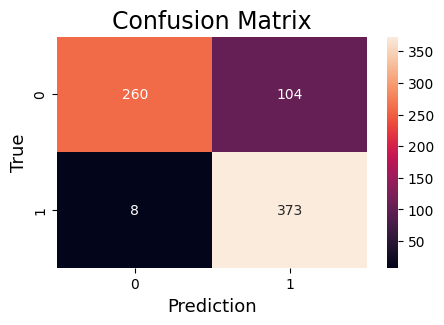

array([[260, 104],
       [  8, 373]])

In [21]:
confusion_matrix(y_true, y_pred)

In [22]:
y_pred, y_true, y_prob, _ = get_predictions(model, test_loader)
accuracy_score(y_pred, y_true)
# 0.7272727272727273
# 0.7914438502673797

0.7914438502673797

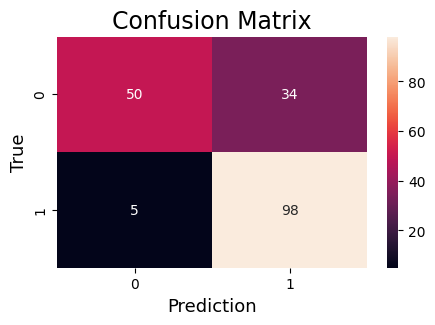

array([[50, 34],
       [ 5, 98]])

In [23]:
confusion_matrix(y_true, y_pred)

# show

0.9731404958677686


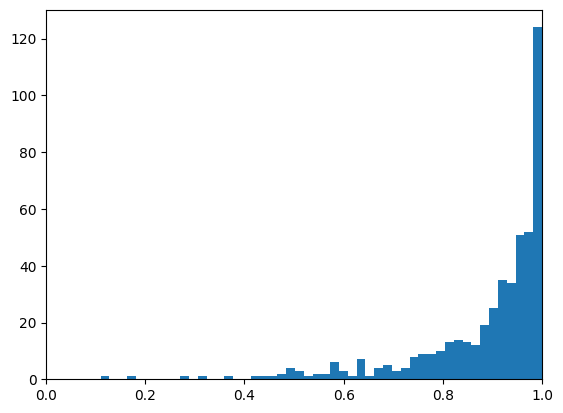

In [24]:
pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
print(accuracy_score(y_pred, y_true))

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9173553719008265
# 0.9442148760330579

0.6919642857142857


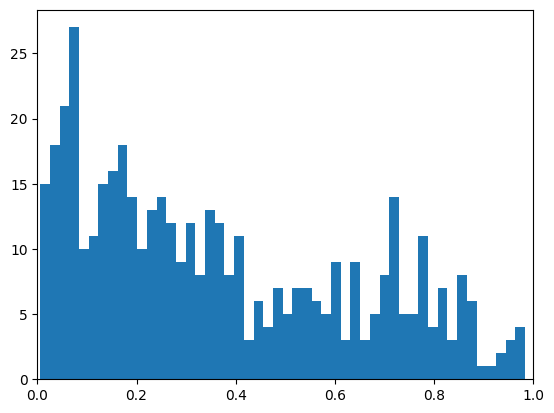

In [25]:
neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, neg_loader)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.6875
# 0.7790178571428571

prob > 0.8
count : 393 out of 484
pic idx : [0, 1, 3, 4, 5, 6, 7, 8]


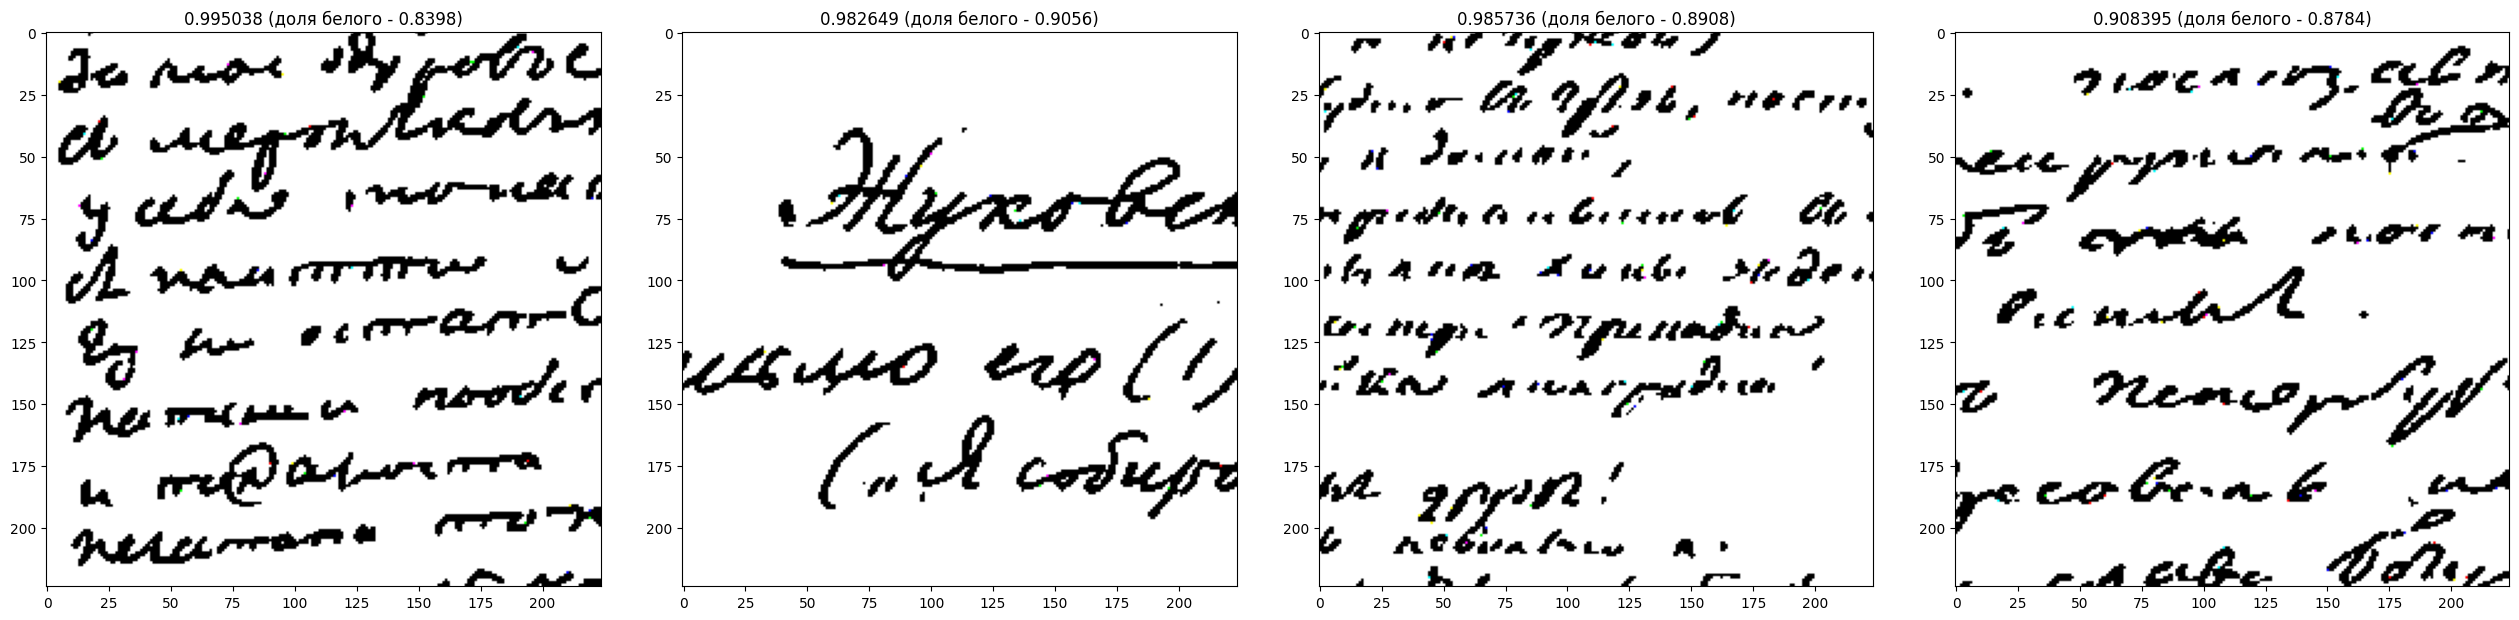

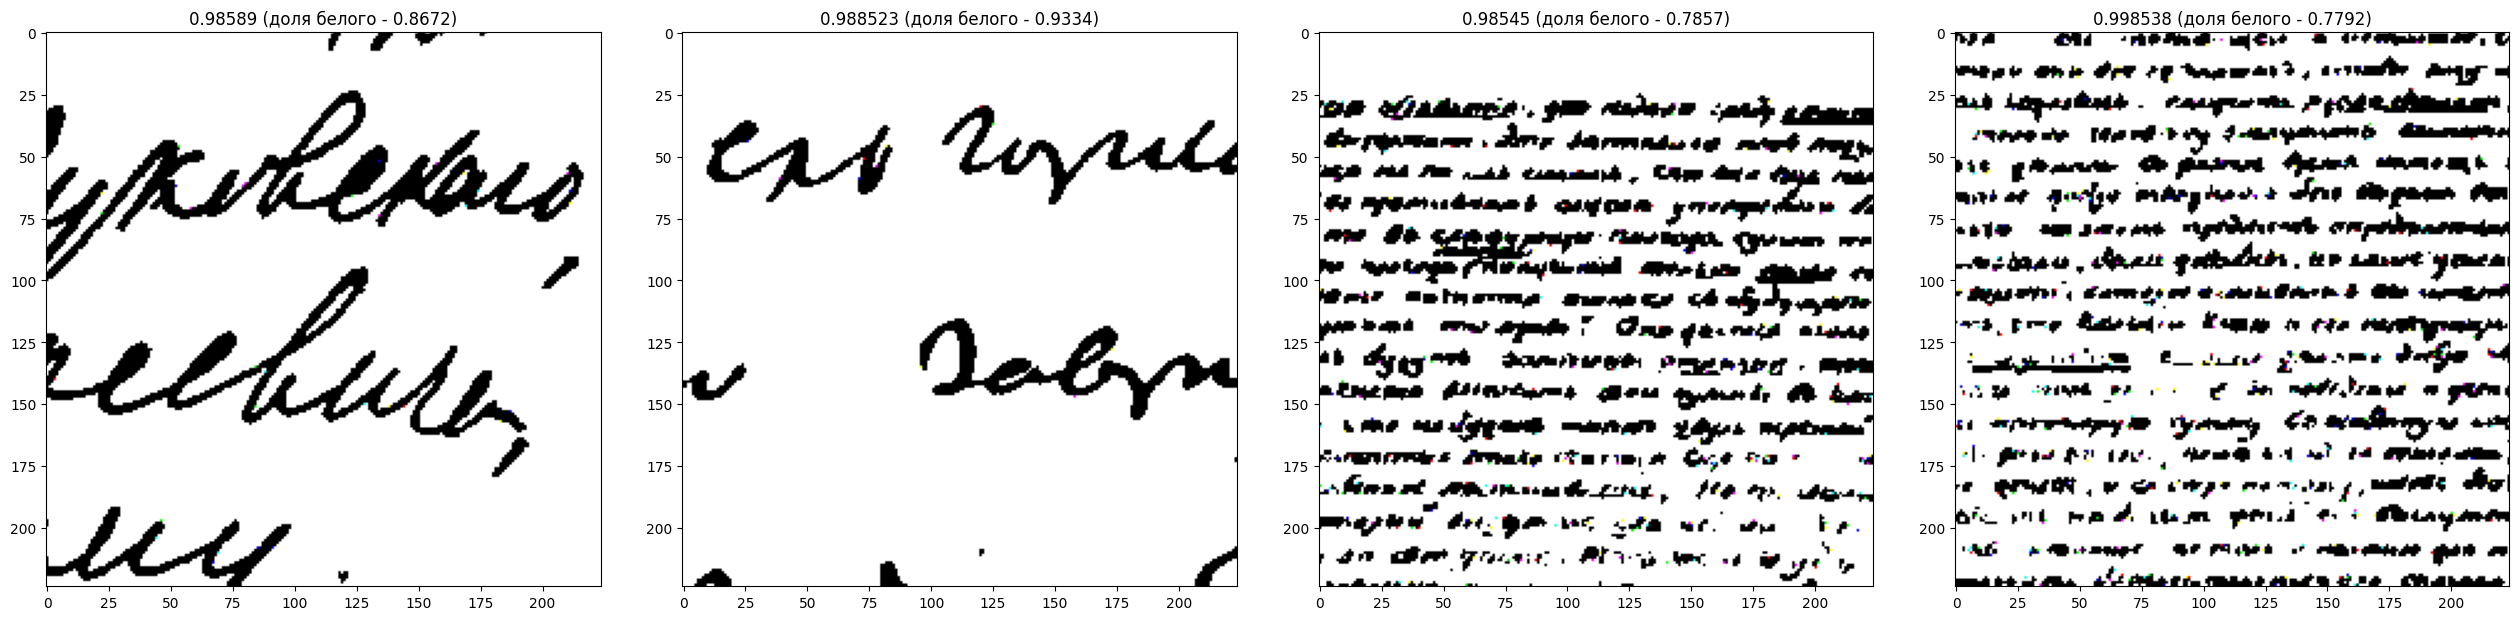

In [26]:
y_pred, _, y_prob, X = show_result(model, pos_loader, 0.8, greater = True, col = 8)

prob < 0.6
count : 29 out of 484
pic idx : [10, 33, 45, 78, 81, 86, 102, 107]


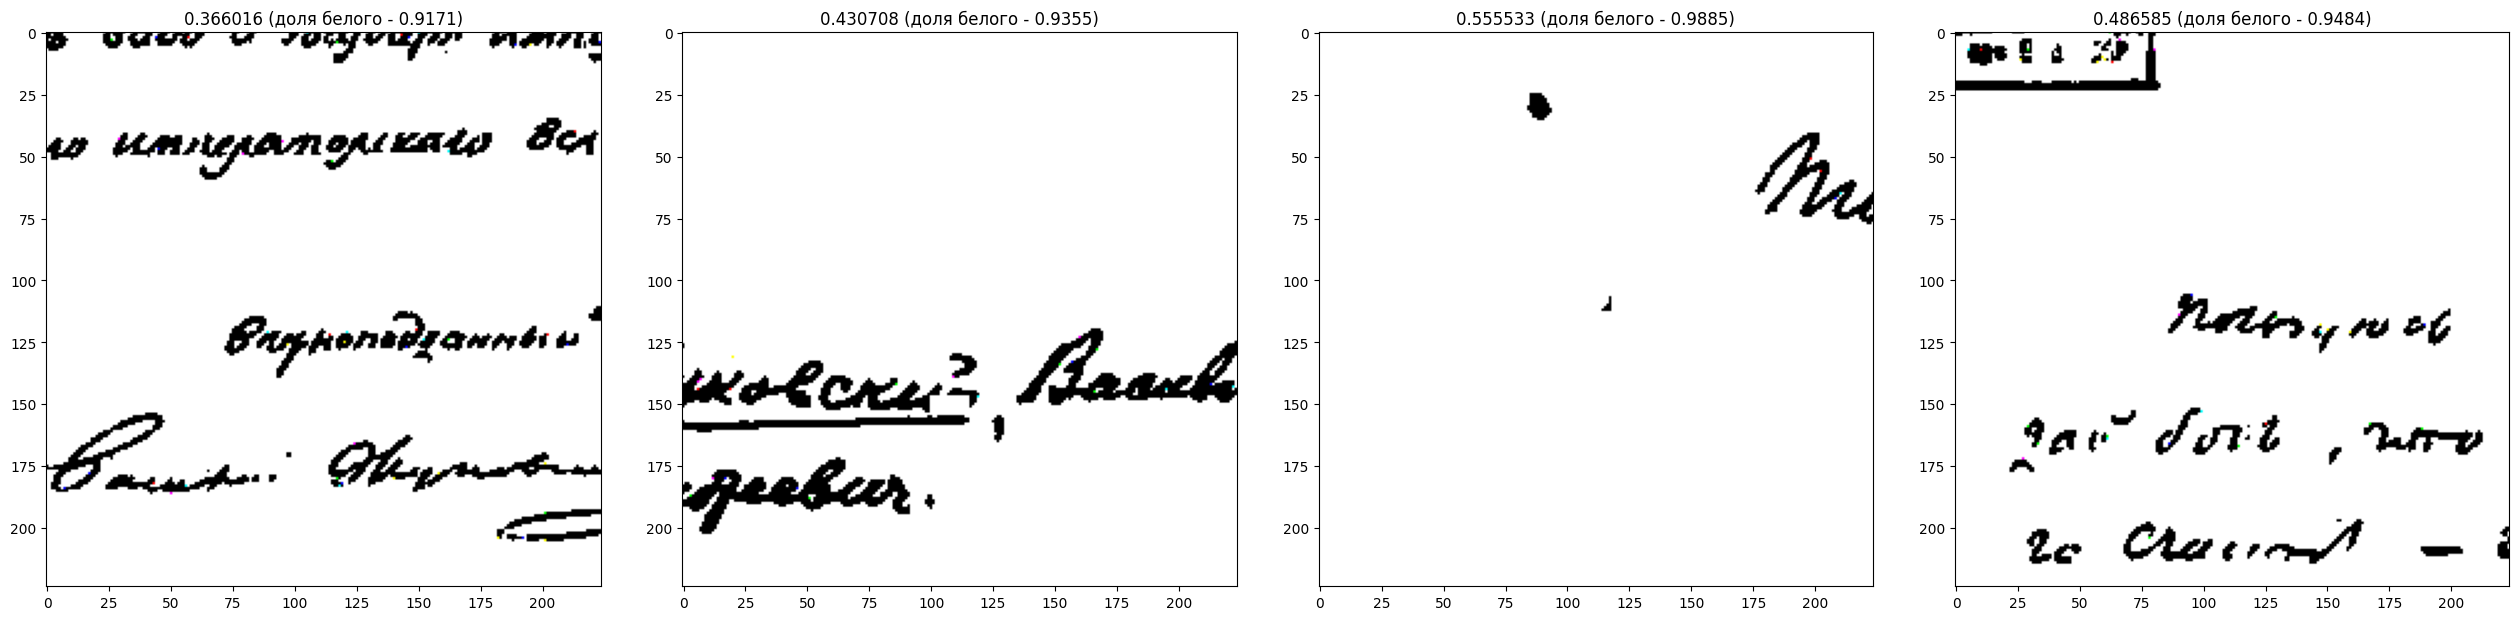

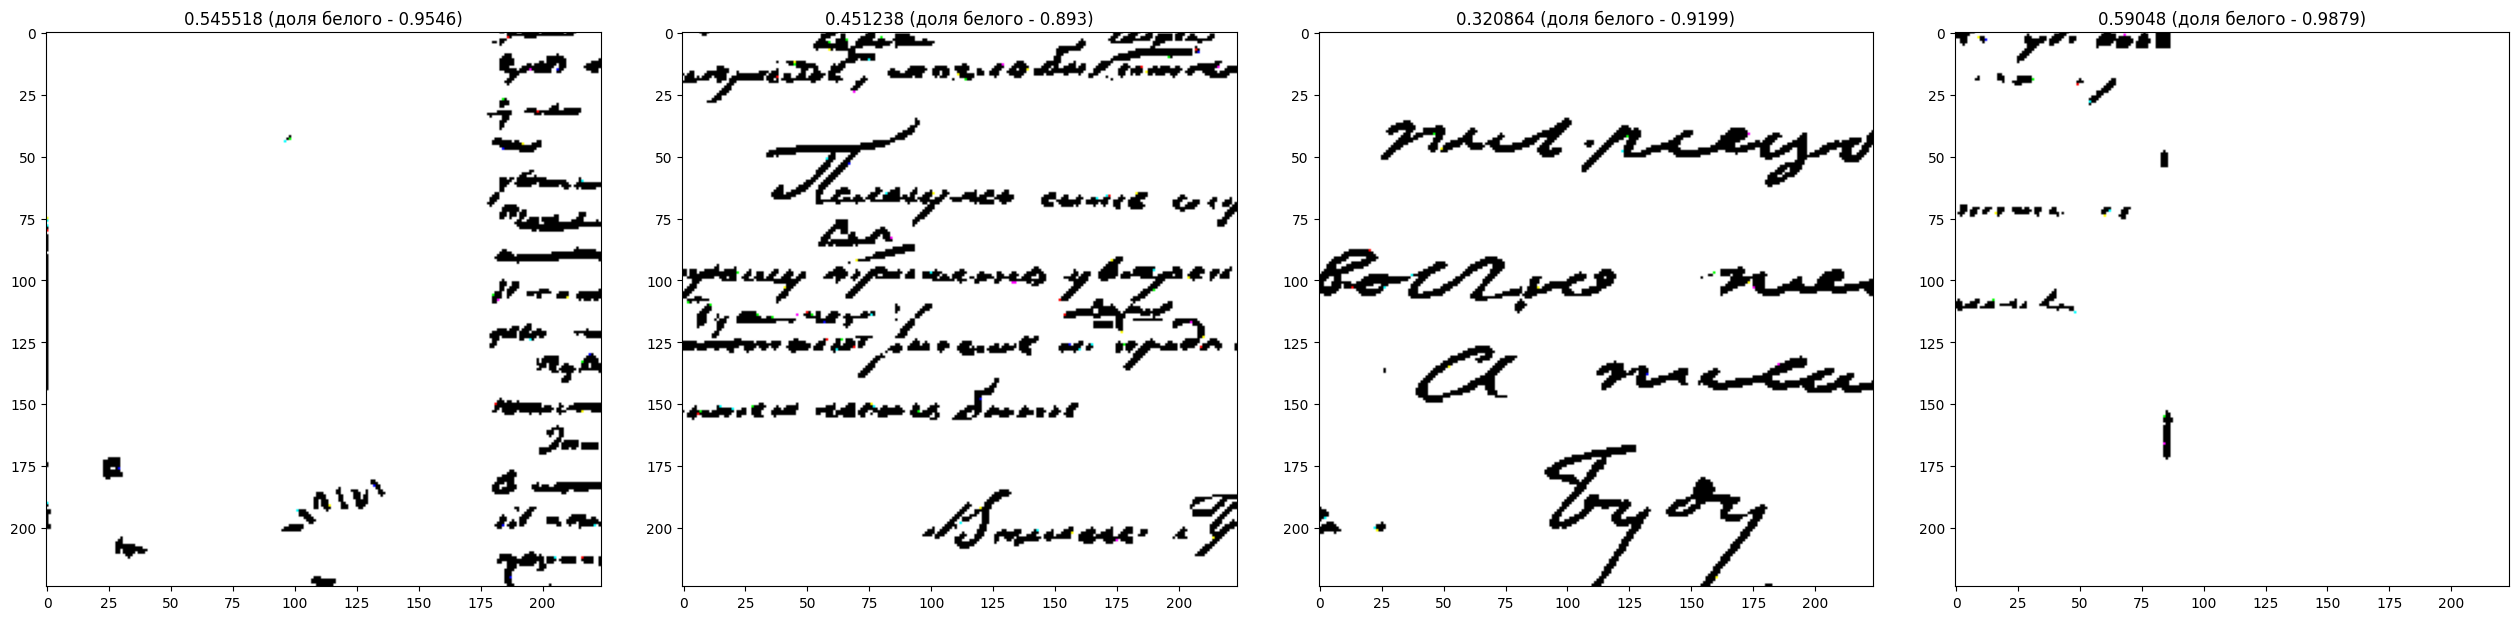

In [27]:
y_pred, _, y_prob, X = show_result(model, pos_loader, 0.6, greater = False, col = 8)

In [28]:
y_pred, _, y_prob, X = show_result(model, neg_loader, 0.3, greater = False, col = 24, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
y_pred, _, y_prob, X = show_result(model, neg_loader, 0.79, greater = True, col = 24, sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
# img = pos_dataset[0][0]
# img.shape

In [31]:
# s = set()
# for i in range(300):
#     for j in range(300):
#         s |= {tuple(img[:, i, j].tolist())}

# s

In [32]:
# x, num = np.unique(img.max(dim = 0)[0], return_counts = True)
# x, num

In [33]:
# plt.figure(figsize=(20, 20))

# plt.imshow(np.transpose(img, (1, 2, 0)))

# on the entire dataset

In [34]:
y_pred, _, y_prob, X = show_result(model, neg_loader, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
y_pred, _, y_prob, X = show_result(model, pos_loader, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.